(transd_gaussian_mixture)=
# Trans-dimensional Gaussian mixture model

In this tutorial, we demonstrate how to use BayesBay to retrieve a Gaussian Mixture Model (GMM) while treating the number of components in the mixture as unknown. GMMs rest on the assumption that a complex probability distribution can be decomposed into simpler Gaussian distributions. By the weighted sum of these individual Gaussians, GMMs enable the calculation of the probability density function (PDF)
$$f(x) = \sum_{i=1}^N \omega_i \cdot \mathcal{N}(x; \mu_i, \sigma_i),$$

where $\mu_i$ and $\sigma_i$ denote the mean and standard deviation of the $i$th Gaussian, $\mathcal{N}(x; \mu_i, \sigma_i)$, and the weights are chosen such that $\sum_{i=1}^N \omega_i = 1$.

GMMs are particularly useful to analyze datasets whose underlying distribution is a combination of different Gaussians. This is a common scenario in real-world data, where the considered statistical population often comprises several distinct subpopulations, each characterized by its own distribution. For example, imagine you have the following height measurements from a mixed group of adults and children:

1. **Children (Aged 8 to 12 years)**
   - Measurements: 4000
   - Mean height: 140 cm
   - Standard deviation: 12 cm
2. **Adult Women**
   - Measurements: 3000
   - Mean height: 162 cm
   - Standard deviation: 5 cm
3. **Adult Men**
   - Measurements: 3000
   - Mean height: 177 cm
   - Standard deviation: 6 cm


The height distribution for the above subgroups each follows a Gaussian distribution, but the combined dataset will have three peaks, which cannot be accurately modeled by a single Gaussian. A GMM can model this dataset as a combination of three Gaussians, each capturing the distribution of one subgroup &ndash; children, adult women, and adult men.

In [1]:
import bayesbay as bb
from math import sqrt, pi
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(31)

In [2]:
MEANS = [140, 162, 177]  # Means of the Gaussians
STDS = [12, 5, 6]  # Standard deviations of the Gaussians
WEIGHTS = [0.4, 0.3, 0.3]  # Weights of each Gaussian in the mixture
N_SAMPLES = 50_000 # Number of samples to generate

In [3]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * sqrt(2*pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

## The dataset

In [4]:
assert np.isclose(sum(WEIGHTS), 1), "The weights must sum to 1."

def generate_random_samples(means, stds, weights):
    """Generate random samples for each component of the Gaussian mixture"""
    samples = []
    for mean, std, weight in zip(means, stds, weights):
        n_samples = int(N_SAMPLES * weight) # number of samples for each component
        samples.append(np.random.normal(mean, std, n_samples))
    samples = np.concatenate(samples)
    np.random.shuffle(samples)
    return samples

samples = generate_random_samples(MEANS, STDS, WEIGHTS)

In [5]:
# Define the range of x-values (i.e., heights) over which to evaluate the PDF
x_min, x_max = min(MEANS) - 3 * max(STDS), max(MEANS) + 3 * max(STDS)
xs = np.linspace(x_min, x_max, 1000)

pdf_true = np.zeros_like(xs)
for mean, std, weight in zip(MEANS, STDS, WEIGHTS):
    pdf_true += weight * gaussian(xs, mean, std)

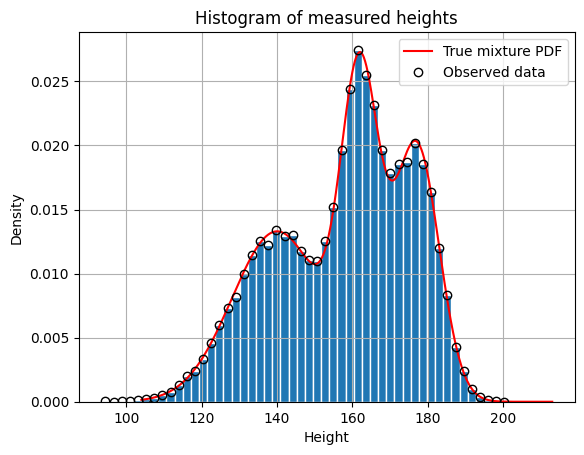

In [6]:
fig, ax = plt.subplots()
ax.set_title('Histogram of measured heights')
data_obs, bins, _ = ax.hist(samples, bins=50, density=True, ec='w')
data_x = (bins[:-1] + bins[1:]) / 2 # take the midpoint of each bin
plt.plot(xs, pdf_true, label='True mixture PDF', color='r')
plt.plot(data_x, data_obs, 'ko', label='Observed data', markerfacecolor='None')

ax.set_xlabel('Height')
ax.set_ylabel('Density')
ax.grid()
ax.legend()
plt.show()

## Setting up the Bayesian sampling

To solve the inverse problem inherent in inferring the weights, mean heights, and standard deviations of the Gaussian mixture (henceforth, $\boldsymbol{\omega}$, $\boldsymbol{\mu}$, and $\boldsymbol{\sigma}$), we need to define:

* A [Parameterization](../api/generated/bayesbay.parameterization.Parameterization), encapsulating the unknown model parameters $\mathbf{m} = [ \boldsymbol{\omega}, \boldsymbol{\mu}, \boldsymbol{\sigma}]$ and their prior probability
* A *forward function*, enabling the prediction of data points $\mathbf{d}_{pred}$ from the model $\mathbf{m}$
* What we refer to as a [Target](../api/generated/bayesbay.Target), that is, a Python object designed to store all information about a given data set

### **Prior probability**

Here, we treat the number of Gaussians in the mixture as unknown and assume that
* $100 \leq \mu_i \leq 200$ cm
* $1 \leq \sigma_i \leq 20$ cm
* $0 \leq \omega_i \leq 1$.

In BayesBay, the above prior information can be implemented through [UniformParameter](../api/generated/bayesbay.parameters.UniformParameter), that is, a free parameter characterized by a uniform prior probability. (Different options for the prior of a free parameter can be implemented via [GaussianParameter](../api/generated/bayesbay.parameters.GaussianParameter) or [CustomParameter](../api/generated/bayesbay.parameters.CustomParameter).)

Finally, note the argument ``perturb_std`` in the below block, taken by `UniformParameter`. The numerical value assigned to this argument represents the standard deviation of the Gaussian used to propose a new model by perturbing the considered parameter at a given Markov-chain iteration.

In [7]:
# mean = bb.parameters.UniformParameter(name="mean", vmin=100, vmax=200, perturb_std=5)
std = bb.parameters.UniformParameter(name="std", vmin=1, vmax=20, perturb_std=1)
weight = bb.parameters.UniformParameter(name="weight", vmin=0, vmax=1, perturb_std=0.05)

### **Parameter space and parameterization**

The above free parameters should be used in BayesBay to create what we call a [ParameterSpace](../api/generated/bayesbay.parameterization.ParameterSpace). Mathematically, `ParameterSpace` can be thought of as a $n$-dimensional vector space. Each point (vector) within this space corresponds to a free parameter in the inference problem, and the position of each point defines the model parameters $\mathbf{m}_i \in \mathbb{R}^n$, with $\mathbf{m}_i \subseteq \mathbf{m}$. In this tutorial, $n$ is treated as unknown, giving rise to a trans-dimensional inversion. This is achieved by setting `n_dimensions=None` in the following block.

From a computer programming perspective, `ParameterSpace` could be seen as a specialized container that not only groups a number of free parameters but also determines their dimensionality. For instance, in this tutorial's case, `ParameterSpace` will contain three distinct free parameters (namely, $\boldsymbol{\omega}$, $\boldsymbol{\mu}$, and $\boldsymbol{\sigma}$). Each of these parameters is a vector, the dimensionality of which matches that of `ParameterSpace` throughout the inversion process. In other words, each time a dimension is added to or removed from `ParameterSpace` (via a [BirthPerturbation](../api/generated/bayesbay.perturbations.BirthPerturbation)/[DeathPerturbation](../api/generated/bayesbay.perturbations.DeathPerturbation)), the dimensionality of the free parameters linked to it is adjusted accordingly. Additionally, `ParameterSpace` underpins the perturbation functions used propose new model parameters at a given Markov chain iteration from the current ones (for more information, see the module [bayesbridge.perturbations](../api/api_standard_perturbations)).

Having defined one or more instances of `ParameterSpace`, these should be used to define a [Parameterization](../api/generated/bayesbay.parameterization.Parameterization). `Parameterization` is a relatively simple object compared to `ParameterSpace`, and its main purpose is to aggregate all model parameters (from all specified instances of `ParameterSpace`) to define $\mathbf{m} = \lbrace \mathbf{m}_1, \mathbf{m}_2, \mathbf{m}_3, \dots \rbrace$.

In [8]:
from bayesbay.discretization import Voronoi1D
voronoi = Voronoi1D(
    name="voronoi", 
    vmin=100,
    vmax=200,
    perturb_std=5,
    n_dimensions=None, 
    n_dimensions_min=1,
    n_dimensions_max=7,
    parameters=[std, weight], 
)
parameterization = bb.parameterization.Parameterization(voronoi)

### **Forward problem**

Another fundamental ingredient in BayesBay is the definition of the forward function. This function is required to return the predicted data in the form of a numpy array, which is then used to calculate the likelihood $p({\bf d}_{obs} \mid {\bf m})$. The forward function should be programmed to take in a [bayesbay.State](../api/generated/bayesbay.State), from which all model parameters can be accessed. Within the forward function passed to BayesBay, function calls to external functions, as illustrated in the code block below, are of course allowed.

In [9]:
def _forward(means, stds, weights):
    weights /= np.sum(weights)
    data_pred = np.zeros_like(data_x)
    for i in range(len(means)):
        data_pred += weights[i] * gaussian(data_x, means[i], stds[i])
    return data_pred

def fwd_function(state: bb.State) -> np.ndarray:
    means = state["voronoi"]['discretization']
    stds = state["voronoi"]['std']
    weights = state["voronoi"]['weight']
    return _forward(means, stds, weights)

### **Observed data: the Target**

In BayesBay, the observed data should be used to define what we call a data [Target](../api/api_standard_target), which allows for treating the data noise as an unknown. This is accomplished by specifying minimum and maximum bounds for the standard deviation of the data and, optionally, for the data correlation. In this instance, we assume that there is no correlation between adjacent data points.

In [10]:
target = bb.Target("my_data", 
                   data_obs, 
                   covariance_mat_inv=1/(1.25e-3)**2,
                   # std_min=0, 
                   # std_max=0.01, 
                   # std_perturb_std=0.001,
                   noise_is_correlated=False)

## Run the Bayesian sampling

We can now use all the defined variables to solve the inference problem. The code provided below is self-explanatory. We sample the posterior using ten Markov chains, each run on a separate CPU for 50,000 iterations. The 2,000 iterations are discarded as the burn-in phase. After the burn-in, we save one model every 500 iterations.


Notice the arguments ``targets`` and ``fwd_functions`` of [bayesbay.BayesianInversion](../api/generated/bayesbay.BayesianInversion): rather than accepting only one data target and forward function, as defined earlier, these can accept a list of targets and a list of functions. This flexibility makes it straightforward to carry out joint inversions of multiple datasets, each potentially associated with different forward functions.

In [11]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=fwd_function, 
    n_chains=15, 
    n_cpus=15
)
inversion.run(
    n_iterations=400_000, 
    burnin_iterations=200_000, 
    save_every=500, 
    print_every=50_000,
    verbose=True, 
)

Chain ID: 5
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 2979/50000 (5.96 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 2/12380 (0.02%)
	DeathPerturbation(voronoi): 1/12453 (0.01%)
	ParamPerturbation(['std', 'weight']): 1874/12567 (14.91%)
	ParamPerturbation(voronoi): 1102/12600 (8.75%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 3212/50000 (6.42 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 8/12413 (0.06%)
	DeathPerturbation(voronoi): 7/12538 (0.06%)
	ParamPerturbation(['std', 'weight']): 1923/12525 (15.35%)
	ParamPerturbation(voronoi): 1274/12524 (10.17%)
Chain ID: 10
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RATE: 6288/50000 (12.58 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 43/10544 (0.41%)
	DeathPerturbation(voronoi): 41/13263 (0.31%)
	ParamPerturbation(['std', 'weight']): 3192/13217 (24.15%)
	ParamPerturbation(voronoi): 3012/12976 (23.21%)
Chain ID: 8
TEMPERATURE: 1
EXPLORED MODELS: 50000
ACCEPTANCE RAT

## Retrieve the results and plot

In [12]:
results = inversion.get_results()
print(results.keys())

dict_keys(['voronoi.n_dimensions', 'std', 'weight', 'voronoi.discretization', 'dpred'])


(array([ 800., 1600., 2184., 1036.,  339.,   41.,    0.,    0.]),
 array([1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <BarContainer object of 8 artists>)

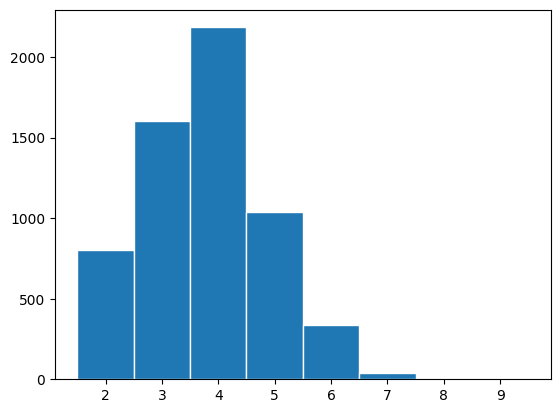

In [13]:
n_gaussians = results['voronoi.n_dimensions']
plt.hist(n_gaussians, bins=np.arange(1.5, 10.5), ec='w')

In [14]:
idx = [i for i, n_comp in enumerate(n_gaussians) if n_comp==4]

In [15]:
means = np.array([results["voronoi.discretization"][i] for i in idx])
stds = np.array([results["std"][i] for i in idx])
weights = np.array([results["weight"][i] for i in idx])

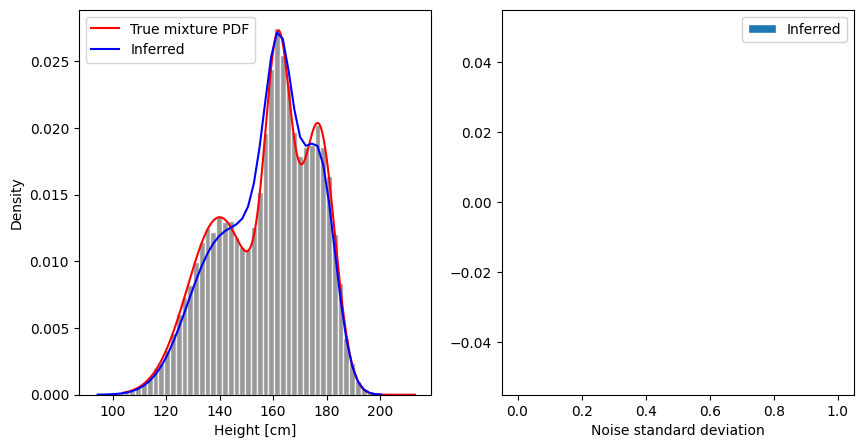

In [16]:
pdf_pred = _forward(np.median(means, axis=0), 
                    np.median(stds, axis=0), 
                    np.median(weights, axis=0)
                    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(samples, bins=50, density=True, ec='w', fc='gray', alpha=0.8)
ax1.plot(xs, pdf_true, label='True mixture PDF', color='r')
ax1.plot(data_x, pdf_pred, label='Inferred', color='b')
ax1.set_xlabel('Height [cm]')
ax1.set_ylabel('Density')
ax1.legend()

ax2.hist(results['my_data.std'], bins=25, ec='w', zorder=100, label='Inferred')
ax2.set_xlabel('Noise standard deviation')
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.legend(framealpha=0.9)
plt.show()

In [17]:
np.median(means, axis=0)

array([139.08888376, 158.75045509, 162.46501049, 177.16388349])

In [18]:
np.median(stds, axis=0)

array([11.7019222 ,  9.84013576,  5.38591829,  6.08115322])

In [19]:
np.median(weights, axis=0)

array([0.3349695 , 0.22906645, 0.24668634, 0.2712395 ])